In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt

In [2]:
expt = nsx.Experiment('test', 'BioDiff2500')
biodiff = expt.getDiffractometer()

In [3]:
#factory = nsx.DataReaderFactory()
#data = factory.create("hdf")
reader = nsx.HDF5DataReader("/home/jonathan/data/biodiff/p11202/p11202.hdf", biodiff)

In [4]:
data = nsx.DataSet(reader, biodiff)
expt.addData(data)

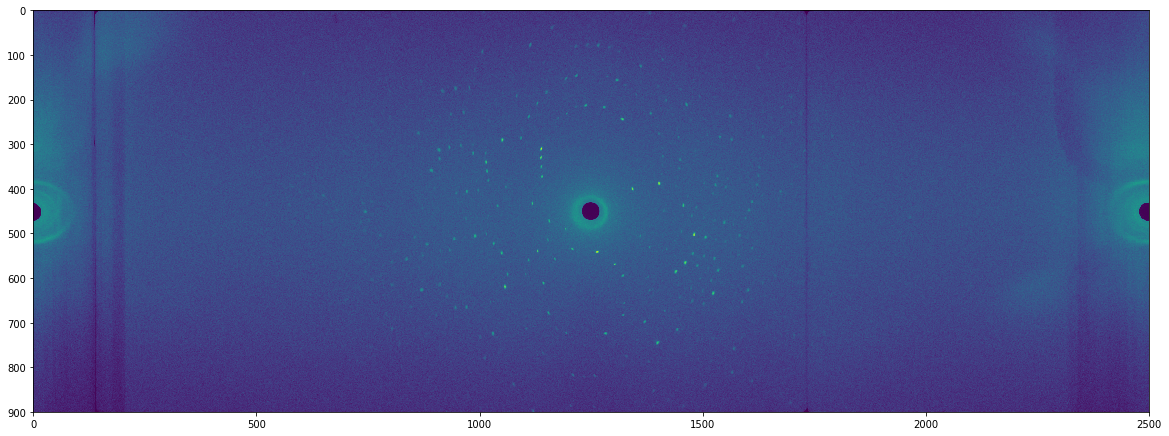

In [5]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(data.getFrame(0)))
plt.show()

In [6]:
kernel = nsx.AnnularKernel(data.getNRows(), data.getNCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [7]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setConfidence(0.98)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

In [8]:
numors = nsx.vector_data()
numors.push_back(data)
finder.find(numors)
peaks = data.getPeaks()
print(peaks.size())

8925


In [9]:
I = 0.0
I2 = 0.0

for peak in peaks:
    intensity = peak.getCorrectedIntensity().getValue()
    I += intensity
    I2 += intensity**2
    
I /= peaks.size()

variance = (I2 - peaks.size()*I*I) / (peaks.size()-1)
std = math.sqrt(variance)

print("average intensity =", I)
print("std intensity     =", std)

average intensity = 217474.78258929015
std intensity     = 200586.49100006957


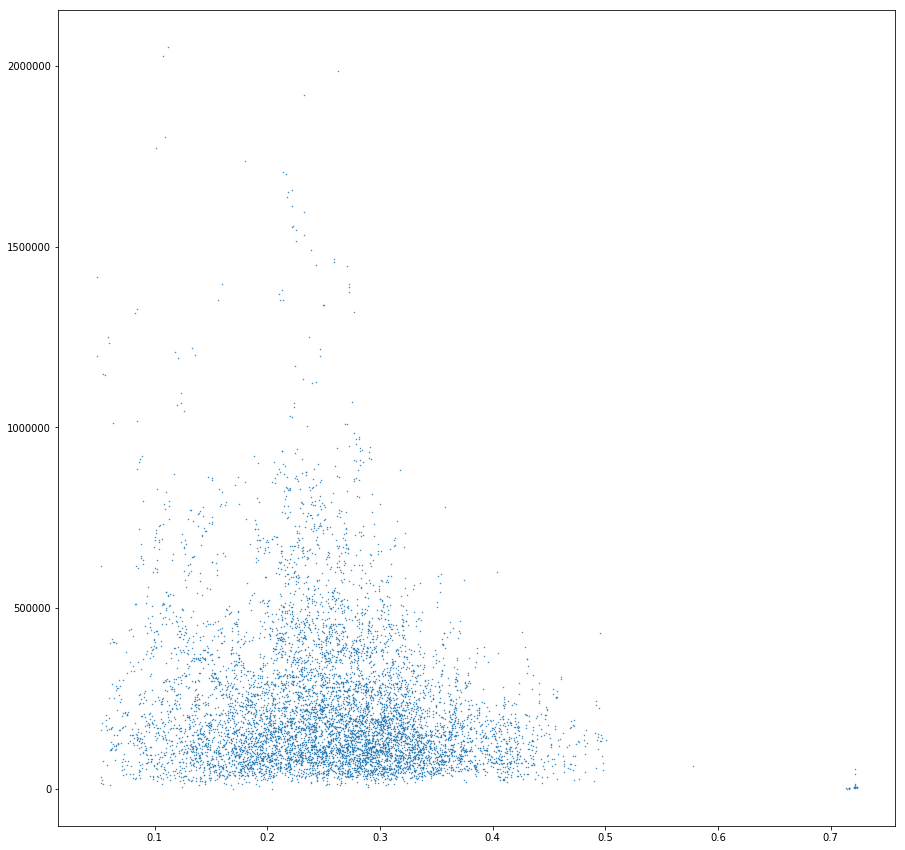

In [10]:
I = []
q = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    I.append(peak.getCorrectedIntensity().getValue())
    q.append(np.linalg.norm(peak.getQ()))

plt.figure(figsize=(15,15))
plt.scatter(q, I, s=0.2)
plt.show()

In [ ]:
indexer = nsx.AutoIndexer(expt, nsx.ProgressHandler())

num_to_index = 0

for peak in peaks:
    d = 1.0 / np.linalg.norm(peak.getQ())
    if peak.isSelected() and d > 2.0 and d < 45.0:
        indexer.addPeak(peak)
        num_to_index += 1

print("indexing", num_to_index, "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = biodiff.getSample()
sample.addUnitCell(uc)

for peak in peaks:
    peak.addUnitCell(uc, True)

num_peaks = len(peaks)

predictor = nsx.PeakPredictor()
predictor._dmin = 1.5
predictor._dmax = 50.0
predictor._searchRadius = 100.0
predictor._peakScale = 1.0
predictor._bkgScale = 3.0
predictor._handler = nsx.ProgressHandler()

predictor.addPredictedPeaks(data)
predicted_peaks = len(data.getPeaks()) - num_peaks

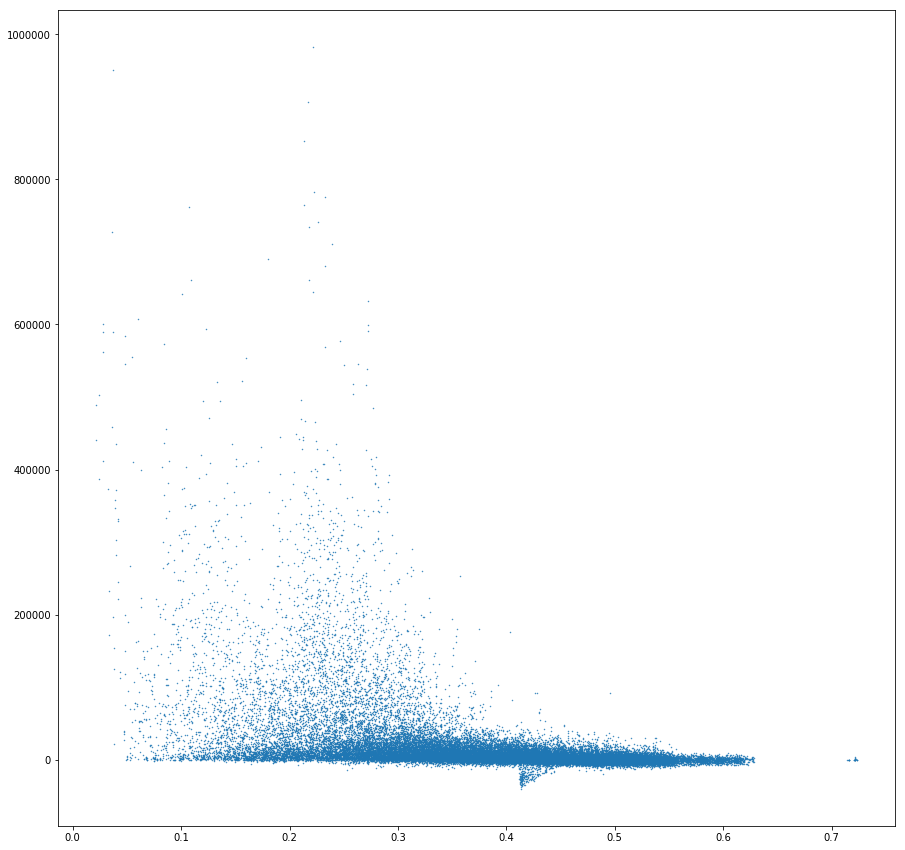

In [12]:
I = []
q = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    I.append(peak.getCorrectedIntensity().getValue())
    q.append(np.linalg.norm(peak.getQ()))

plt.figure(figsize=(15,15))
plt.scatter(q, I, s=0.2)
plt.show()